Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
from glob import glob

In [2]:
## Mounting the google drive to read data set
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/melanoma dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/melanoma dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test')


In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Train Dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Validation dataset 

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualize one instance of all the nine classes present in the dataset

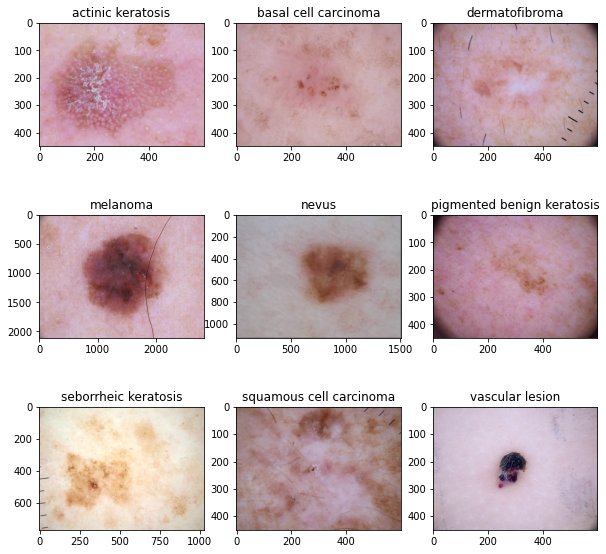

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(10,10))

for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = mpimg.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model 1 : Create the model

In [12]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_class = 9
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(num_class, activation = "softmax"))

### Compile the model

In [13]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Summary of the model

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

### Train the model

In [16]:
epochs = 20
history = model.fit(
                      train_ds,
                      validation_data = val_ds,
                      epochs=epochs
                    )

Epoch 1/20
56/56 [==============================] - 4s 74ms/step - loss: 0.8816 - accuracy: 0.6864 - val_loss: 2.0547 - val_accuracy: 0.4653
Epoch 2/20
56/56 [==============================] - 4s 74ms/step - loss: 0.7871 - accuracy: 0.7221 - val_loss: 2.2089 - val_accuracy: 0.4385
Epoch 3/20
56/56 [==============================] - 4s 75ms/step - loss: 0.7449 - accuracy: 0.7277 - val_loss: 2.7922 - val_accuracy: 0.3870
Epoch 4/20
56/56 [==============================] - 4s 74ms/step - loss: 0.7843 - accuracy: 0.7176 - val_loss: 2.4050 - val_accuracy: 0.4676
Epoch 5/20
56/56 [==============================] - 4s 74ms/step - loss: 0.6627 - accuracy: 0.7746 - val_loss: 2.9117 - val_accuracy: 0.4698
Epoch 6/20
56/56 [==============================] - 4s 74ms/step - loss: 0.5813 - accuracy: 0.8036 - val_loss: 2.9468 - val_accuracy: 0.4631
Epoch 7/20
56/56 [==============================] - 4s 74ms/step - loss: 0.5452 - accuracy: 0.8114 - val_loss: 2.9091 - val_accuracy: 0.4586
Epoch 8/20
56

### Visualizing training results

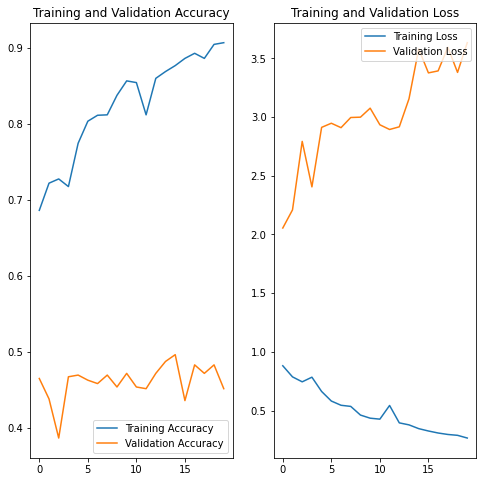

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Base Model1 has high training accuracy but low validation accuracy, which means that model is overfitting. 

## Model 2

In [18]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

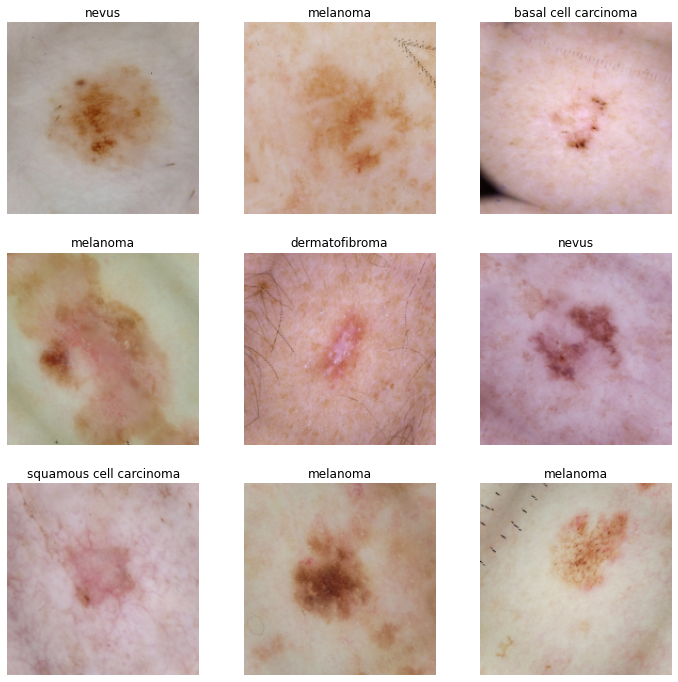

In [19]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augmentation(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


### Create the model2


In [20]:
## We  can use Dropout layer as there is an evidence of overfitting in above model

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([data_augmentation,layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compiling the model2

In [21]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


### Training the model2

In [22]:
## Your code goes here, note: train your model for 20 epochs

epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 7s 97ms/step - loss: 2.0611 - accuracy: 0.2148 - val_loss: 1.9992 - val_accuracy: 0.2349
Epoch 2/30
56/56 [==============================] - 5s 98ms/step - loss: 1.8619 - accuracy: 0.3047 - val_loss: 2.1156 - val_accuracy: 0.1834
Epoch 3/30
56/56 [==============================] - 5s 94ms/step - loss: 1.7765 - accuracy: 0.3566 - val_loss: 1.6775 - val_accuracy: 0.4251
Epoch 4/30
56/56 [==============================] - 6s 103ms/step - loss: 1.6664 - accuracy: 0.4129 - val_loss: 1.5457 - val_accuracy: 0.4698
Epoch 5/30
56/56 [==============================] - 5s 95ms/step - loss: 1.5502 - accuracy: 0.4386 - val_loss: 1.5178 - val_accuracy: 0.4765
Epoch 6/30
56/56 [==============================] - 5s 94ms/step - loss: 1.5354 - accuracy: 0.4459 - val_loss: 1.4914 - val_accuracy: 0.4653
Epoch 7/30
56/56 [==============================] - 5s 93ms/step - loss: 1.5411 - accuracy: 0.4548 - val_loss: 1.6101 - val_accuracy: 0.4362
Epoch 8/30
5

### Visualizing the results

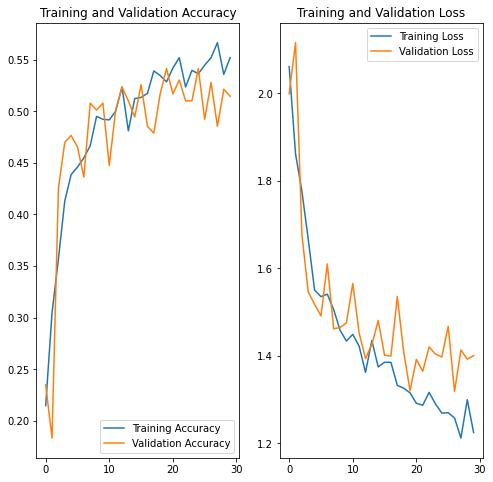

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Training and Validatioon accuracy is low for model2 after we apply dropout and augmentation

## Model 3

#### Find the distribution of classes in the training dataset.

Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
# Check the distribution of classes 

image_dict = {}
for classname in class_names:
    image_dict[classname] = len(list(data_dir_train.glob(classname+'/*.jpg')))   
print(image_dict)  


{'actinic keratosis': 114, 'basal cell carcinoma': 376, 'dermatofibroma': 95, 'melanoma': 438, 'nevus': 357, 'pigmented benign keratosis': 462, 'seborrheic keratosis': 77, 'squamous cell carcinoma': 181, 'vascular lesion': 139}


In [25]:
df = pd.DataFrame()
counts = list(image_dict.values())
df['class'] = class_names
df['count'] = counts

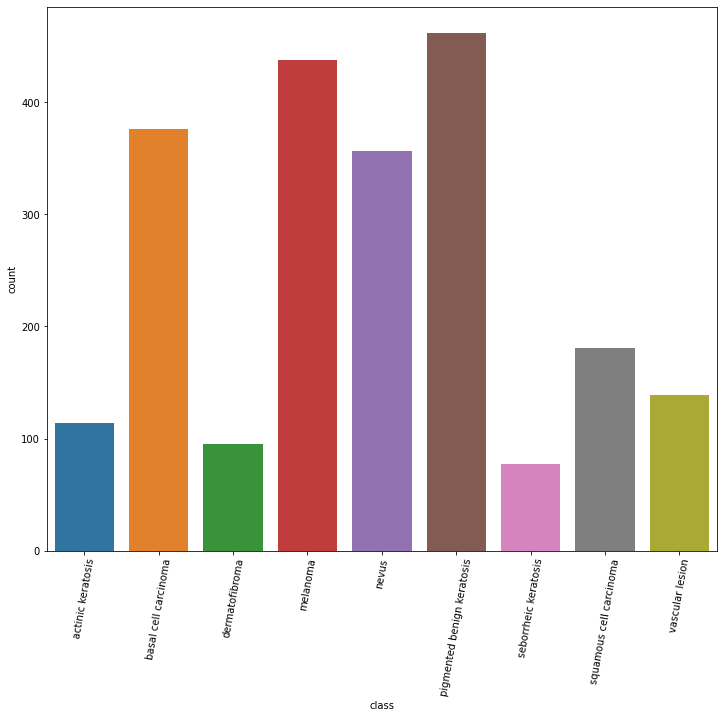

In [26]:
# Plotting the bar graph for each class

import seaborn as sns
plt.figure(figsize=(12, 10))
sns.barplot(x = df['class'], y = df['count'], data = df)
plt.xticks(rotation=80)
plt.show()


#### - Which class has the least number of samples?

'seborrheic keratosis' class has least number of samples.This classs contain only 77 samples

#### - Which classes dominate the data in terms proportionate number of samples?

'pigmented benign keratosis' class has highest number of sampples 462

#### To Rectify the class imbalance we can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset="/content/gdrive/MyDrive/Colab Notebooks/melanoma dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability = 0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/melanoma dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6B121A6D90>: 100%|██████████| 500/500 [00:20<00:00, 24.63 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/melanoma dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6B11EA8D10>: 100%|██████████| 500/500 [00:23<00:00, 20.90 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/melanoma dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6B11E47110>: 100%|██████████| 500/500 [00:25<00:00, 19.41 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/melanoma dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6B156E4C10>: 100%|██████████| 500/500 [01:39<00:00,  5.03 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/melanoma dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7F6B11E87750>: 100%|██████████| 500/500 [01:28<00:00,  5.63 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/melanoma dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6B92060110>: 100%|██████████| 500/500 [00:18<00:00, 27.00 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/melanoma dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6B91DE9110>: 100%|██████████| 500/500 [00:43<00:00, 11.53 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/melanoma dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6B11E8FA10>: 100%|██████████| 500/500 [00:17<00:00, 27.96 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/melanoma dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6BFDDB1A10>: 100%|██████████| 500/500 [00:18<00:00, 26.94 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [32]:
# creating a dictionary to prepare a dataframe
dataframe_dict = dict(zip(path_list_new, lesion_list_new))
new_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [33]:
new_df.head()

,Path,Label
0,/content/gdrive/MyDrive/Colab Notebooks/melano...,actinic keratosis
1,/content/gdrive/MyDrive/Colab Notebooks/melano...,actinic keratosis
2,/content/gdrive/MyDrive/Colab Notebooks/melano...,actinic keratosis
3,/content/gdrive/MyDrive/Colab Notebooks/melano...,actinic keratosis
4,/content/gdrive/MyDrive/Colab Notebooks/melano...,actinic keratosis


In [34]:
new_df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
nevus                         500
melanoma                      500
dermatofibroma                500
seborrheic keratosis          500
pigmented benign keratosis    500
vascular lesion               500
squamous cell carcinoma       500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [36]:
data_dir_train=pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/melanoma dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                  data_dir_train,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset = 'training',
                                  image_size=(img_height, img_width),
                                  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


####  Create a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                  data_dir_train,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset ='validation',
                                  image_size=(img_height, img_width),
                                  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create model3 

In [38]:
## your code goes here

# rescaling layer
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)),
    # 1st conv layer
  layers.Conv2D(16, 3, padding='same', activation='relu'),
    # maxpooling layer
  layers.MaxPooling2D(),
    # dropout layer
  layers.Dropout(0.25),
    #2nd conv layer
  layers.Conv2D(32, 3, padding='same', activation='relu'),
    # maxpooling layer
  layers.MaxPooling2D(),
    # dropout layer
  layers.Dropout(0.25),
    #3rd conv layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),
    # maxpooling layer
  layers.MaxPooling2D(),
    # dropout layer
  layers.Dropout(0.25),
    # flatten
  layers.Flatten(),
    # 1st dense layer
  layers.Dense(128, activation='relu'),
    # output layer with softmax
  layers.Dense(num_classes,activation='softmax')
])

#### Compile  model3 

In [39]:
# compiling the model with adam optimizer and sparse_categorical_crossentropy loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### Train model3

In [40]:

epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 33s 182ms/step - loss: 2.2941 - accuracy: 0.1500 - val_loss: 2.1590 - val_accuracy: 0.1938
Epoch 2/30
169/169 [==============================] - 31s 179ms/step - loss: 1.7982 - accuracy: 0.3082 - val_loss: 1.6514 - val_accuracy: 0.3972
Epoch 3/30
169/169 [==============================] - 31s 179ms/step - loss: 1.4951 - accuracy: 0.4316 - val_loss: 1.4827 - val_accuracy: 0.4469
Epoch 4/30
169/169 [==============================] - 31s 180ms/step - loss: 1.3713 - accuracy: 0.4820 - val_loss: 1.4394 - val_accuracy: 0.4729
Epoch 5/30
169/169 [==============================] - 31s 180ms/step - loss: 1.2998 - accuracy: 0.5102 - val_loss: 1.3513 - val_accuracy: 0.4870
Epoch 6/30
169/169 [==============================] - 31s 180ms/step - loss: 1.2260 - accuracy: 0.5410 - val_loss: 1.2545 - val_accuracy: 0.5457
Epoch 7/30
169/169 [==============================] - 31s 180ms/step - loss: 1.1129 - accuracy: 0.5842 - val_loss: 1.2095 - val_ac

####  Visualize the model results

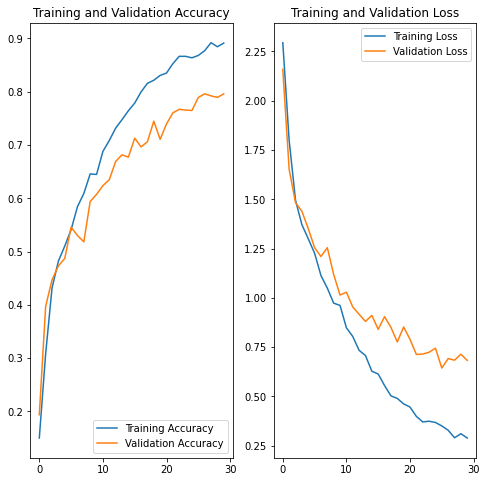

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Finally we could handle both overfitting and class imbalance issue and the model performance has increased considerably.